In [1]:
import celerite
from celerite import terms
import cPickle as pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
c = 2.99792458e8   # m/s

Construct the data:

In [2]:
data = pickle.load(open( "binary_data.p", "rb" ))
print len(data)

73


In [22]:
wave_lo = np.log(4680.)
wave_hi = np.log(4700.)
subset = []
#for i in range(len(data)):
for i in range(0,len(data),10):
    m = (data[i][0] > wave_lo) & (data[i][0] < wave_hi)
    x = np.copy(data[i][0][m])
    y = np.log(np.copy(data[i][1][m]))
    yerr = np.copy(data[i][2][m]/data[i][1][m])
    subset.append((x,y,yerr))

Set up the GP:

In [23]:
kernel = terms.RealTerm(np.log(0.04), -np.log(0.001), bounds=((np.log(.01*0.04),np.log(100.*0.04)),(None, None)))
gp = celerite.GP(kernel,
                 log_white_noise=-9.6,
                 fit_white_noise=True)

In [24]:
gp.get_parameter_dict()

OrderedDict([('kernel:log_a', -3.2188758248682006),
             ('kernel:log_c', 6.9077552789821368),
             ('log_white_noise:value', -9.5999999999999996)])

Set up for marginalization of the scales:

In [25]:
nepoch = len(subset)
eye = np.eye(nepoch)
ndata_byepoch = [len(d[0]) for d in subset]
design = np.repeat(eye, ndata_byepoch, axis=0)
print design.shape
print design

(15992, 8)
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


Set up the minimization:

In [26]:
def shift_and_flatten(xis, data):
    ndata = sum([len(d[0]) for d in data])
    ndata_byepoch = [len(d[0]) for d in data]
    n = 0
    x = np.empty(ndata)
    y = np.empty(ndata)
    yerr = np.empty(ndata)
    for i, d in enumerate(data):
        length = len(d[0])
        x[n:n+length] = d[0] - xis[i]
        y[n:n+length] = d[1]
        yerr[n:n+length] = d[2]
        n += length
    return x, y, yerr

In [27]:
def set_params(params):
    xis, gp_par = params[0:len(subset)], params[len(subset):]
    x, y, yerr = shift_and_flatten(xis, subset)
    inds = np.argsort(x)
    x = x[inds]
    y = y[inds]
    yerr = yerr[inds]
    A = np.copy(design)[inds,:]    
    gp.set_parameter_vector(gp_par)
    gp.compute(x, yerr)
    scales = np.linalg.solve(np.dot(A.T, gp.apply_inverse(A)), np.dot(A.T,gp.apply_inverse(y)))
    ndata_byepoch = [len(d[0]) for d in subset]
    y[np.argsort(inds)] -= np.repeat(scales, ndata_byepoch)
    return scales, xis, y

In [28]:
def nll(params):
    scales, xis, y = set_params(params)
    return -gp.log_likelihood(y) + 1./2. # * np.sum(xis**2)

In [29]:
def xi_to_v(xi):
    # translate ln(wavelength) Doppler shift to a velocity in m/s
    return np.tanh(xi) * c
 
def v_to_xi(v):
    return np.arctanh(v/c)

In [47]:
from scipy.io.idl import readsav
print len(subset)
data_dir = "/Users/mbedell/Documents/Research/HARPSTwins/Results/"
pipeline = readsav(data_dir+'HIP14501_result.dat') 

xis0 = np.empty(len(subset))
rvs = np.empty(len(subset))
dates = np.empty(len(subset))
for i in range(len(subset)):
    rvs[i] = pipeline.rv[i*10] * 1.e3
    xis0[i] = v_to_xi(rvs[i])
    dates[i] = pipeline.date[i*10]

#xis0 = np.zeros(len(subset))

print rvs
print xis0

8
[ 7024.81401469  7018.33914306  7018.41943078  7013.38662595  7013.40349903
  7010.31415633  7011.44683261  7011.45511287]
[  2.34322573e-05   2.34106595e-05   2.34109273e-05   2.33941396e-05
   2.33941959e-05   2.33838910e-05   2.33876692e-05   2.33876968e-05]


In [31]:
p0 = np.append(xis0, gp.get_parameter_vector())
print p0
bounds = [(-1e-4, 1e-4) for d in subset] + gp.get_parameter_bounds()
print bounds

scales, xis, y = set_params(p0)

[  2.34322573e-05   2.34106595e-05   2.34109273e-05   2.33941396e-05
   2.33941959e-05   2.33838910e-05   2.33876692e-05   2.33876968e-05
  -3.21887582e+00   6.90775528e+00  -9.60000000e+00]
[(-0.0001, 0.0001), (-0.0001, 0.0001), (-0.0001, 0.0001), (-0.0001, 0.0001), (-0.0001, 0.0001), (-0.0001, 0.0001), (-0.0001, 0.0001), (-0.0001, 0.0001), (-7.8240460108562919, 1.3862943611198906), (None, None), (None, None)]


In [32]:
soln = minimize(nll, p0, bounds=bounds, method='L-BFGS-B')
scales, xis, y = set_params(soln.x)

In [33]:
print soln
print xi_to_v(xis)

      fun: -51377.33996393969
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
      jac: array([  5.54348399e+08,   2.48961575e+09,   1.35958611e+09,
         8.44379681e+08,   1.85254909e+09,  -4.37129497e+08,
         1.69710740e+09,   3.87505017e+09,   3.39593680e+02,
         3.33736534e+02,   6.23249798e+02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 372
      nit: 9
   status: 0
  success: True
        x: array([  2.33285069e-05,   2.33299004e-05,   2.33277863e-05,
         2.33503340e-05,   2.33274189e-05,   2.33230805e-05,
         2.33279470e-05,   2.33326142e-05,  -3.21652125e+00,
         8.85016604e+00,  -1.08674514e+01])
[ 6993.71042795  6994.12819544  6993.49437927  7000.25402401  6993.38425186
  6992.0836171   6993.54256546  6994.94177478]


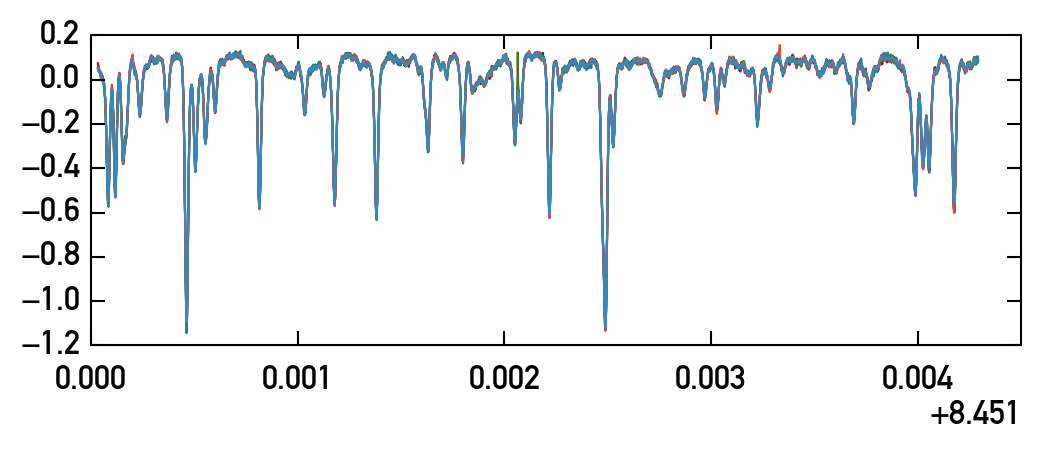

In [34]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
for i,d in enumerate(subset):
    ax.plot(d[0] - xis[i],d[1] - scales[i])

Check out the prediction:

In [35]:
def prediction(params):
    scales, xis, y = set_params(params)
    result_flat = gp.predict(y, return_cov=False)
    x, _, _ = shift_and_flatten(xis, subset)
    inds = np.argsort(x)
    result_sorted = result_flat[np.argsort(inds)]
    result = []
    n = 0
    for i,d in enumerate(subset):
        length = len(d[0])
        result.append(result_sorted[n:n+length] + scales[i])
        n += length
    return result

In [36]:
mu = prediction(soln.x)

In [37]:
print mu

[array([ 9.76401075,  9.75999039,  9.75446371, ...,  9.79698042,
        9.79629621,  9.79946736]), array([ 10.40144585,  10.39745157,  10.39220619, ...,  10.43473472,
        10.4340644 ,  10.43712465]), array([ 9.84986403,  9.84579981,  9.84017589, ...,  9.88274158,
        9.88198882,  9.88518652]), array([ 9.63071877,  9.62653406,  9.62181819, ...,  9.66484347,
        9.66447789,  9.66558864]), array([ 10.36653845,  10.36244606,  10.35685807, ...,  10.39942431,
        10.39861469,  10.40184837]), array([ 9.40645197,  9.4021614 ,  9.39685578, ...,  9.43946501,
        9.43837393,  9.44165151]), array([ 10.37508572,  10.37103744,  10.36542838, ...,  10.40797783,
        10.40725131,  10.41044318]), array([ 10.68636563,  10.6823031 ,  10.67729907, ...,  10.71990792,
        10.71922962,  10.72215889])]


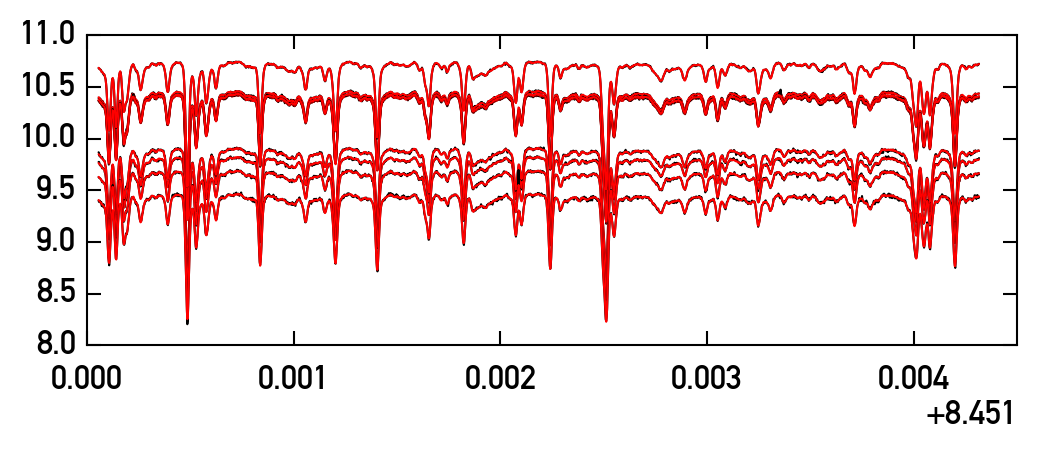

In [38]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
for i,d in enumerate(subset):
    ax.plot(d[0], d[1], color='black')
    ax.plot(d[0], mu[i], color='red')

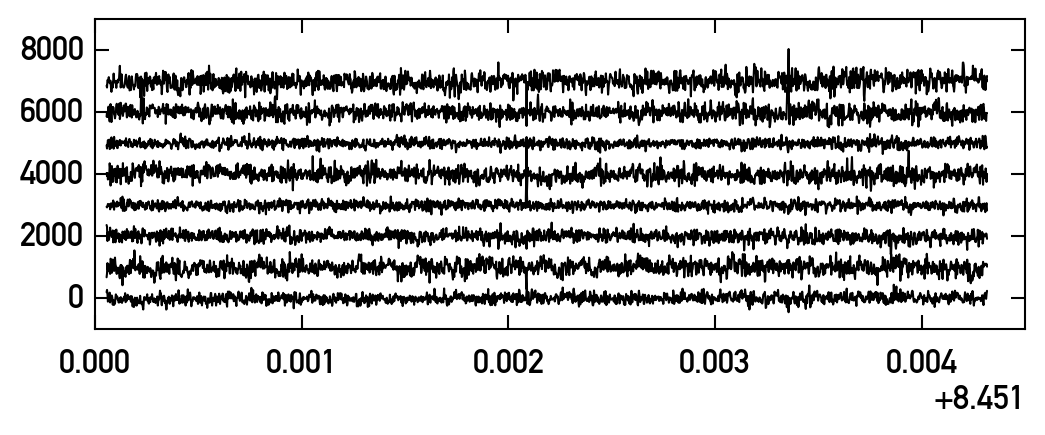

In [39]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
for i,d in enumerate(subset):
    ax.plot(d[0], (np.exp(d[1]) - np.exp(mu[i])) + 1000*i, color='black')


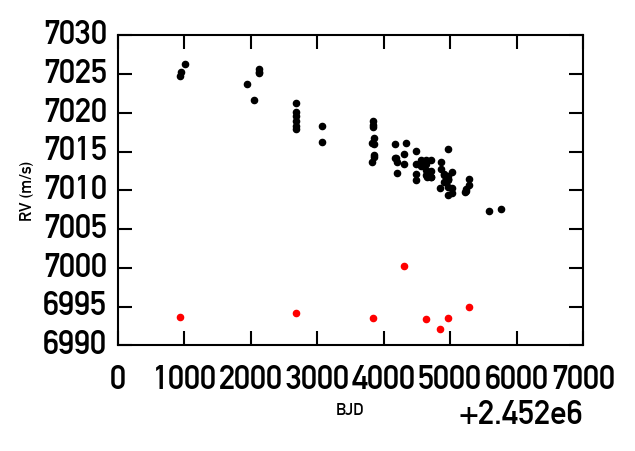

In [55]:
plt.scatter(pipeline.date, pipeline.rv*1.e3, color='black', label='HARPS RVs')
plt.scatter(dates, xi_to_v(xis), color='red', label='Avast RVs')
plt.xlabel('BJD')
plt.ylabel('RV (m/s)')

In [68]:
rvs1 = np.arange(5) + 2000.
rvs2 = np.arange(5)
xis1 = v_to_xi(rvs1)
xis2 = v_to_xi(rvs2)
print (xis1 - xis1[0]) - (xis2 - xis2[0])
print xi_to_v((xis2 - xis1[0]))

[  0.00000000e+00   1.48034310e-19   2.96915654e-19   4.46644444e-19
   5.94676686e-19]
[-2000. -1999. -1998. -1997. -1996.]
